In [3]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ Klasyfikator zespołowy (głosowanie większościowe)

    Parametry
    ----------
    classifiers : tablicopodobny, wymiary = [n_klasyfikatorów]
      Różne klasyfikatory tworzące zespół

    vote : łańcuch znaków, {'classlabel', 'probability'} (domyślnie: 'classlabel')
      Jeżeli jest wybrany argument 'classlabel', to prognoza jest przeprowadzana przy użyciu funkcji
        argmax wobec etykiet klas. W przeciwnym wypadku ('probability'), wynik funkcji argmax wobec sumy
        prawdopodobieństw zostaje użyty do prognozowania etykiety klas (zalecane dla skalibrowanych klasyfikatorów).

    weights : tablicopodobne, wymiary = [n_klasyfikatorów], Opcjonalny, (domyślnie: None)
      Po wprowadzeniu listy wartości typu `int` lub `float`, Klasyfikatory są ważone pod kątem ważności. Jeśli
      `weights=None`, wykorzystywane są takie same wagi.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Dopasowywanie klasyfikatorów.

        Parametry
        ----------
        X : {tablicopodobny, macierz rzadka}, wymiary = [n_próbek, n_cech]
            Macierz próbek uczących.

        y : tablicopodobny, wymairy = [n_próbek]
            Wektor docelowych etykiet klas.

        Zwraca
        -------
        self : obiekt

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("parametr vote przyjmuje wyłącznie wartości 'probability' lub 'classlabel'"
                             "; wybrano (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Liczba klasyfikatorów musi być równa liczbie wag'
                             '; dostępne wagi: %d, klasyfikatory: %d'
                             % (len(self.weights), len(self.classifiers)))

        # dzięki klasie LabelEncoder etykiety klas rozpoczynają się 
        # od wartości 0, co jest bardzo ważne podczas wywołania np.argmax
        # w self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Prognozowanie etykiet klas dla próbki X.

        Parametry
        ----------
        X : {tablicopodobny, macierz rzadka}, wymiary = [n_próbek, n_cech]
            Macierz próbek uczących.

        Zwraca
        ----------
        maj_vote : tablicopodobny, wymiary = [n_próbek]
            Przewidywane etykiety klas.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # wartość 'classlabel'

            #  zbiera wyniki z wywołań metody clf.predict
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Prognozowania prawdopodobieństwa przynależności próbki X do danej klasy.

        Parametry
        ----------
        X : {tablicopodobny, macierz rzadka}, wymiary = [n_próbek, n_cech]
            Wektory uczenia, gdzie n_próbek oznacza
            liczbę próbek, a n_cech – liczbę cech.

        Zwraca
        ----------
        avg_proba : tablicopodobny, wymiary = [n_próbek, n_klas]
            Ważone, uśrednione prawdopodobieństwo wystąpienia każdej klasy na daną próbkę.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Pobiera nazwy parametrów klasyfikatora dla klasy GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [4]:
from sklearn import datasets
from distutils.version import LooseVersion as Version
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X , y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=1)

In [6]:
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2', 
                          C=0.001, 
                          random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2 ,metric='minkowski')
pipe1 = Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],['clf',clf3]])
clf_labels = ['Regresja Logiczna','Drzewo decyzyjne','k-najblisi sąsiedzi']
for clf, label in zip([pipe1, clf2,pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print(scores.mean(),scores.std(),label)


0.916666666667 0.20069324298 Regresja Logiczna
0.916666666667 0.153659074288 Drzewo decyzyjne
0.933333333333 0.104083299973 k-najblisi sąsiedzi


In [7]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Głosowanie wiekszoscowe']
all_clf = [pipe1, clf2,pipe3,mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
print(scores.mean(),scores.std(),label)

0.966666666667 0.1 Głosowanie wiekszoscowe


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf, 
               clf_labels, colors, linestyles):

    # zakładamy, że etykieta klasy pozytywnej wynosi 1
    y_pred = clf.fit(X_train, 
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, 
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (obszar AUC=%0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')

plt.tight_layout()
#plt.savefig('./rysunki/07_04.png', dpi=300)
plt.show()

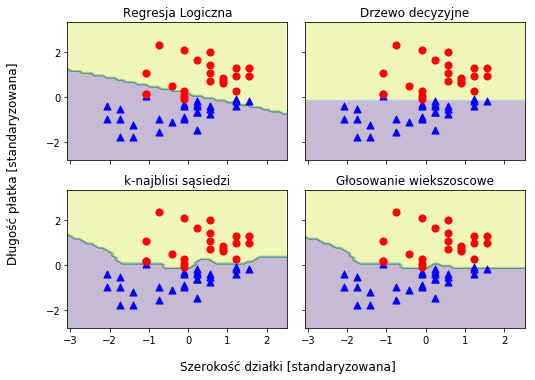

In [9]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Szerokość działki [standaryzowana]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Długość płatka [standaryzowana]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.tight_layout()
#plt.savefig('./rysunki/07_05', bbox_inches='tight', dpi=300)
plt.show()

In [35]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Etykieta klas', 'Alkohol', 'Kwas jabłkowy', 'Popiół', 
'Zasadowość popiołu', 'Magnez', 'Całk. zaw. fenoli', 
'Flawonoidy', 'Fenole nieflawonoidowe', 'Proantocyjaniny', 
'Intensywność koloru', 'Odcień', 'Transmitancja 280/315 nm', 'Prolina']

# porzuca klasę 1
df_wine = df_wine[df_wine['Etykieta klas'] != 1]

y = df_wine['Etykieta klas'].values
X = df_wine[['Alkohol', 'Odcień']].values

In [47]:
from sklearn.preprocessing import LabelEncoder
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.40, 
                             random_state=1)

In [54]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)
bag = BaggingClassifier(base_estimator = tree,
                        n_estimators = 500,
                        max_samples=1.0,
                        max_features =1.0,
                        bootstrap=True,
                        bootstrap_features = False,
                        n_jobs =1,
                        random_state=1
                       )


In [55]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
## naSZE DRZEWO do porownania
print(tree_train, tree_test)

1.0 0.833333333333


In [56]:
bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print(bag_train, bag_test)

1.0 0.895833333333


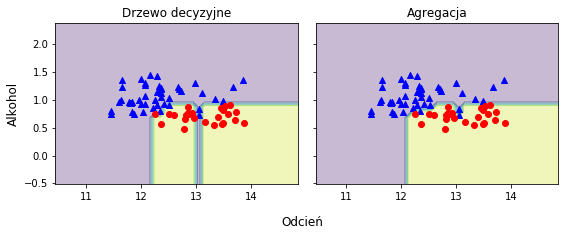

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Drzewo decyzyjne', 'Agregacja']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', marker='^')
    
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red', marker='o')
    
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alkohol', fontsize=12)
plt.text(10.2, -1.2, 
         s='Odcień', 
         ha='center', va='center', fontsize=12)
    
plt.tight_layout()
#plt.savefig('./rysunki/07_08.png', 
#            dpi=300, 
#            bbox_inches='tight')
plt.show()

In [66]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=0)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=0)
tree= tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print(tree_train, tree_test)

0.845070422535 0.854166666667


In [67]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print(ada_train, ada_test)

1.0 0.875


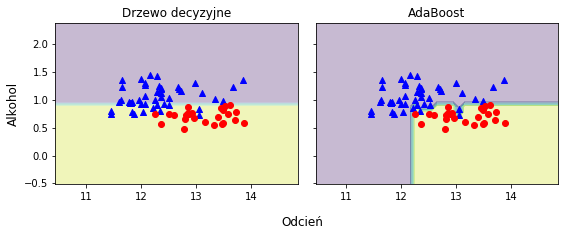

In [68]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Drzewo decyzyjne', 'AdaBoost']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alkohol', fontsize=12)
plt.text(10.2, -1.2, 
         s='Odcień', 
         ha='center', va='center', fontsize=12)
    
plt.tight_layout()
#plt.savefig('./rysunki/07_11.png', 
#           dpi=300, 
#           bbox_inches='tight')
plt.show()